# Import

In [1]:
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal
from scipy.optimize import curve_fit
import scipy.fftpack
from scipy import interpolate
from cycler import cycler
from inspect import signature

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))
#%matplotlib notebook
%matplotlib inline

# Reading files

In [3]:
def read_data_file(common_folder, folder_in, Rl, N, file_type, spec_type, spec_component, run_files) :
    nb_of_runs = len(run_files)
    for run_index in list(range(nb_of_runs)) :
        folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
        if (run_files[run_index] < 1000) :
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
        else : 
            file = folder + file_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%06d" % run_files[run_index] + ".table"
        file_data = []
        print('reading file: ' + file)
        averaging_weight = (run_files[run_index]+1)/(sum(run_files)+nb_of_runs)
        for line in open(file) :
            temp_array_line = []
            if line[0] == '#' :          #skip commented lines
                continue
            else :
                temp_array_line=list(map(float, line.split( )))
                temp_array_line = [t * averaging_weight for t in temp_array_line]
                file_data.append(temp_array_line)  
        if (run_index == 0) : 
            accumulated_data = file_data.copy()
        else : 
            accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
    k = np.array(accumulated_data[0])
    nb_of_modes = np.array(accumulated_data[1])
    average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
    for i in list(range(average_data.shape[0])) : 
        average_data[i, :] = np.array(accumulated_data[i+2])
    t = average_data[:,0]
    numpy_file_table = np.array(average_data[:,1:])
    return [k, nb_of_modes, t, numpy_file_table]

In [4]:
common_folder = "/home/gorbunov8a/data/filtered_advection/"
Rl = 160; N=512
folder_in = "large_window/"
run_files = [9,11,11]
spec_type = "lin"
spec_component = "avg"

In [5]:
[k, nb_of_modes, t, total_t] = read_data_file(common_folder, folder_in, Rl, N, "total_transfer_corr", spec_type, spec_component, run_files)
[k, nb_of_modes, t, t_ss] = read_data_file(common_folder, folder_in, Rl, N, "t_ss", spec_type, spec_component, run_files)
[k, nb_of_modes, t, t_sss] = read_data_file(common_folder, folder_in, Rl, N, "t_sss", spec_type, spec_component, run_files)
[k, nb_of_modes, t_corr, correlation] = read_data_file(common_folder, folder_in, Rl, N, "two_point_corr", spec_type, "avg", run_files)

reading file: /home/gorbunov8a/data/filtered_advection/rl160_N512/large_window/run1/total_transfer_corr_lin_Cavg_wi=009.table
reading file: /home/gorbunov8a/data/filtered_advection/rl160_N512/large_window/run2/total_transfer_corr_lin_Cavg_wi=011.table
reading file: /home/gorbunov8a/data/filtered_advection/rl160_N512/large_window/run3/total_transfer_corr_lin_Cavg_wi=011.table
reading file: /home/gorbunov8a/data/filtered_advection/rl160_N512/large_window/run1/t_ss_lin_Cavg_wi=009.table
reading file: /home/gorbunov8a/data/filtered_advection/rl160_N512/large_window/run2/t_ss_lin_Cavg_wi=011.table
reading file: /home/gorbunov8a/data/filtered_advection/rl160_N512/large_window/run3/t_ss_lin_Cavg_wi=011.table
reading file: /home/gorbunov8a/data/filtered_advection/rl160_N512/large_window/run1/t_sss_lin_Cavg_wi=009.table
reading file: /home/gorbunov8a/data/filtered_advection/rl160_N512/large_window/run2/t_sss_lin_Cavg_wi=011.table
reading file: /home/gorbunov8a/data/filtered_advection/rl160_N512

In [6]:
### RESHAPE
# tL1 = transfer_f1.shape[0]
# tL2 = transfer_f2.shape[0]
# transfer_f2 = transfer_f2[(tL2-tL1)//2:(tL2+tL1)//2:,::]

In [7]:
#total_t = total_t*(run_files[0]-1.0)/run_files[0]

In [8]:
# total_t - all energy transgers to the shell k
# t_ss - energy transfers between small scales
# t_sss - only transfers with all three small modes
# t_sls - energy transfer between small scales with a large scale mediator mode
# t_sl - non-local transfer to small scales from large scales
t_sls = t_ss - t_sss    
t_sl = total_t - t_ss

# Define parameters

In [9]:
# PARAMETERS
#nu = 0.01
nu = 0.0001
pi = np.pi
if (Rl == 60) :
    lmbda = 0.378
    eta = 0.0254807  
    L = 2.23  
    dissipation_rate = 0.2244E-5
    e_kine = 0.39
    cut_off_k = 12.0
if (Rl == 90) :
    lmbda = 0.2352
    eta = 0.126e-1
    dissipation_rate = 0.3919e-4
    L = 2.2
    cut_off_k = 25.0
if (Rl == 160):
    lmbda = 0.155
    eta = 0.006436  
    L = 2.2
    dissipation_rate = 0.6E-3  
    cut_off_k = 40.0

t0=dissipation_rate**(-1/3)*L**(2/3) #large scale eddy-turnover time
print(t0)
spatial_scales = np.array([L, lmbda, eta])
normalization_status = True


ikf = int(np.searchsorted(k, cut_off_k))
ik2f = int(np.searchsorted(k, 2*cut_off_k))
print(ik2f)

20.055401945071857
79


In [10]:
#check the integral scale
l_large=eta*(3/20*Rl)**2
print(l_large)

3.7071359999999998


In [11]:
#check urms
# Urms1 = np.sqrt(2.0*e_kine/3.0)
# print(Urms1)

Urms2 = L**(1.0/3.0)*dissipation_rate**(1/3)
print(Urms2)

0.10969613104865238


# Normalization

In [12]:
t_length=t.shape[0]
wavenumbers_length=k.shape[0]
if normalization_status :
#     k_norm_coef = L
#     t_norm_coef = 1.0/t0
#     t=t*t_norm_coef
#     k=k*k_norm_coef
#     spatial_scales = 1.0/k_norm_coef * spatial_scales
    
    normalization = (correlation[0,:])**(-1)
else : 
    normalization = np.ones(wavenumbers_length)

wn_scales = 2.0*np.pi/spatial_scales
kL = 2.0*pi/L; klmbda = 2.0*pi/lmbda; keta = 2.0*pi/eta

avg_coef = 4.0*pi*(k**2.0)/nb_of_modes

In [13]:
# wavenumber index corresponding to lambda
np.searchsorted(k, wn_scales[1])

40

# Plotting params

In [14]:
kmin = ikf
kmax = np.max(k) -10
nb_of_curves = 8
indices_of_k_to_plot=np.int_(np.linspace(kmin, kmax, nb_of_curves))
#indices_of_k_to_plot.append(40)
print(indices_of_k_to_plot)

plt.rc('axes', labelsize=12)  
plt.rc('axes', titlesize=12)  
plt.rc('legend', fontsize=12)  

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
default_cycler = cycler(cycler(linestyle=['-', '--', ':', '-.'])*cycler(color=colors))
plt.rc('axes', prop_cycle=default_cycler)

[ 39  68  98 127 157 186 216 245]


In [15]:
indices_of_k_to_plot.shape

(8,)

# Spatial compensated spectrum from C_2(t=0,k)

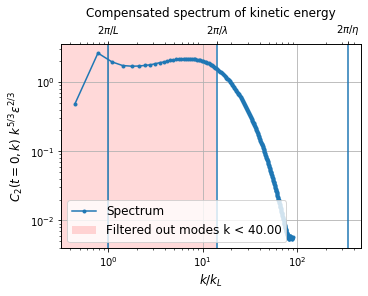

In [16]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(5,4))
kinetic_energy = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    kinetic_energy[ik] = 0.5*correlation[0,ik]
ax.plot(k/kL, kinetic_energy*k**(5.0/3.0)*dissipation_rate**(-2.0/3.0)*avg_coef, '.-', label='Spectrum')
#ax.plot(k, 5e-4*k**(-5.0/3.0), label=r'$k^{-5/3}$')
ax.set(xscale='log',yscale='log',xlabel=r'$k/k_L$', ylabel=r'$C_2(t=0,k) \ k^{5/3} \epsilon^{2/3}$', title='Compensated spectrum of kinetic energy')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()

vertical_lines=wn_scales/kL
for line in vertical_lines : ax.axvline(x=line)
ax.axvspan(0, cut_off_k/kL, facecolor='red', alpha=0.15, label='Filtered out modes k < %2.2f' % (cut_off_k))
    
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
#lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
lgd = ax.legend()
#plt.show()

# pp = PdfPages('Images/transfer_decomp/filtered_spec.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

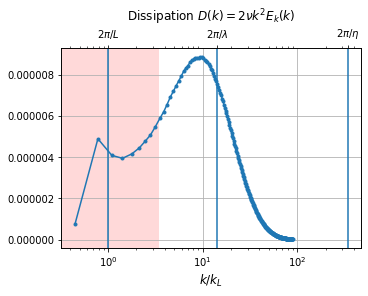

In [17]:
dissipation_spec = 2*nu*(kinetic_energy)*(k**2.0)

fig, ax = plt.subplots(figsize=(5,4), constrained_layout=True)
ax.plot(k/kL, dissipation_spec*avg_coef, '.-',label=r'Dissipation $D(k) = 2 \nu k^2 E_k(k)$')
ax.set(xscale='log',yscale='linear',xlabel=r'$k/k_L$', title=r'Dissipation $D(k) = 2 \nu k^2 E_k(k)$'); #ax.set(ylim=[-0.35e-5,10e-6])
ax.grid()

ax.axvspan(0, 10/kL, facecolor='red', alpha=0.15, label=r'Filtered out modes $k < k_c =$%2.2f' % (cut_off_k))

vertical_lines=wn_scales/kL
for line in vertical_lines : ax.axvline(x=line)
ax2 = ax.twiny()
ax2.set(xscale=ax.get_xscale(), yscale=ax.get_yscale(), xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])
plt.show()

In [18]:
#total dissipation rate (epsilon)
print(np.trapz(2.0*nu*kinetic_energy*k**(2.0), x=k))
print(np.sum(2.0*nu*kinetic_energy*k**(2.0)))
print(dissipation_rate)

0.0005828722361383286
0.0005843018641746535
0.0006


In [19]:
ik_max_dissip = np.argmax(dissipation_spec)
print(ik_max_dissip)

24


# Energy transfer spectrum from T(t=0,k)

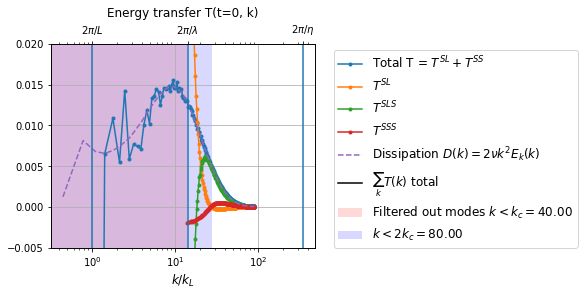

In [20]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)
coefficient = 1.0/dissipation_rate
ax.plot(k/kL, total_t[t_length//2,::]*coefficient*avg_coef, '.-', label=r'Total T = $T^{SL} + T^{SS}$')
ax.plot(k[ikf::]/kL, t_sl[t_length//2,ikf::]*coefficient, '.-', label=r'$T^{SL}$')
#ax.plot(k[ikf::]/kL, t_ss[t_length//2,ikf::], '.-', label=r'$T^{SS} = T^{SSS} + T^{SLS}$')
ax.plot(k[ikf::]/kL, t_sls[t_length//2,ikf::]*coefficient, '.-', label=r'$T^{SLS}$')
ax.plot(k[ikf::]/kL, t_sss[t_length//2,ikf::]*coefficient, '.-', label=r'$T^{SSS}$')
ax.plot(k/kL, dissipation_spec*coefficient*avg_coef, '--', label=r'Dissipation $D(k) = 2 \nu k^2 E_k(k)$')
ax.plot(k/kL, np.sum(total_t[t_length//2,::]*avg_coef)*coefficient*np.ones_like(k), '-', label=r'$\sum_k T(k)$ total', color='black')
#ax.plot(k/kL, np.sum(transf1_spec)*np.ones_like(k), '-', label=r'$\sum_k T(k)$ filtered')
#ax.plot(k, 5e-4*k**(-5.0/3.0), label=r'$k^{-5/3}$')
ax.set(xscale='log',yscale='linear',xlabel=r'$k/k_L$', title='Energy transfer T(t=0, k)'); ax.set(ylim=[-0.05e-1,0.02])
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()

ax.axvspan(0, cut_off_k/kL, facecolor='red', alpha=0.15, label=r'Filtered out modes $k < k_c =$%2.2f' % (cut_off_k))
ax.axvspan(0, 2*cut_off_k/kL, facecolor='blue', alpha=0.15, label=r'$k < 2k_c = $%2.2f' % (2*cut_off_k))

vertical_lines=wn_scales/kL
for line in vertical_lines : ax.axvline(x=line)
ax2 = ax.twiny()
ax2.set(xscale=ax.get_xscale(), yscale=ax.get_yscale(), xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])

lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# pp = PdfPages('Images/transfer_decomp/transfer_spec.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

In [21]:
print(np.sum(total_t[t_length//2,::]*avg_coef)/dissipation_rate)
print(np.sum(total_t[t_length//2,::])/dissipation_rate)
print(np.trapz(total_t[t_length//2,::],x=k)/dissipation_rate)
print(np.trapz(total_t[t_length//2,::]*avg_coef,x=k)/dissipation_rate)

-0.05402136906959681
-0.000666283908245145
0.11903853217135625
0.07668621961512069


# Energy flux spectrum from T(t=0,k)

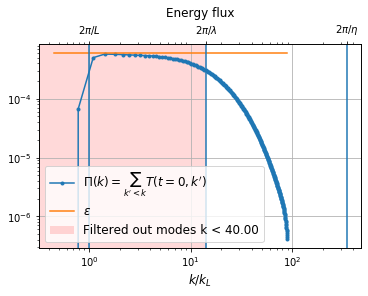

In [22]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(5,4))
flux_total_t = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    flux_total_t[ik] = -np.sum(total_t[t_length//2,0:ik])
    #flux_total_t[ik] = -np.trapz(total_t[t_length//2,0:ik], x=k[0:ik])
ax.plot(k/kL, flux_total_t, '.-', label=r'$\Pi(k) = \sum_{k^\prime < k}  T(t=0, k^\prime)$')
ax.plot(k/kL, dissipation_rate*np.ones_like(k), '-', label=r'$\epsilon$')
ax.set(xscale='log',yscale='log',xlabel=r'$k/k_L$', title='Energy flux')
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid()

ax.axvspan(0, cut_off_k/kL, facecolor='red', alpha=0.15, label='Filtered out modes k < %2.2f' % (cut_off_k))

vertical_lines=wn_scales/kL
for line in vertical_lines : ax.axvline(x=line)
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])

#lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
lgd = ax.legend()
plt.show()

# pp = PdfPages('Images/transfer_decomp/flux_spec.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

# Total energy transfer time dependance

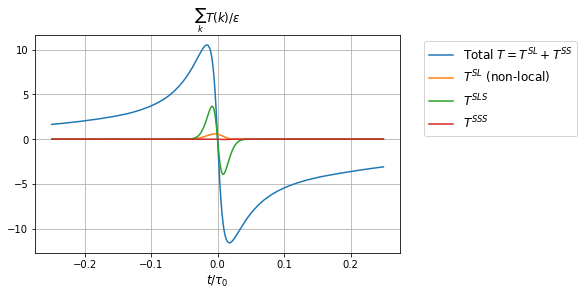

In [23]:
fig, ax = plt.subplots(constrained_layout=True,figsize=(8,4))
normalization_coef = 1.0/dissipation_rate
ax.plot(t/t0, np.sum(total_t[:,::]*normalization_coef, axis=1), '-', label=r'Total $T = T^{SL} + T^{SS}$')
ax.plot(t/t0, np.sum(t_sl[:,ikf::]*normalization_coef, axis=1), '-', label=r'$T^{SL}$ (non-local)')
#ax.plot(t/t0, np.sum(t_ss[:,ikf::]*normalization_coef, axis=1), '-', label=r'$T^{SS} =T^{SSS} + T^{SLS}$')
ax.plot(t/t0, np.sum(t_sls[:,ikf::]*normalization_coef, axis=1), '-', label=r'$T^{SLS}$')
ax.plot(t/t0, np.sum(t_sss[:,ikf::]*normalization_coef, axis=1), '-', label=r'$T^{SSS}$')
ax.set(xlabel=r'$t/\tau_0$', title=r'$\sum_{k} T(k)/\epsilon$'); ax.grid()
#ax.set(yscale='log')
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.show()

# pp = PdfPages('Images/transfer_decomp/sum_transfer_vs_time.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

# Plot C2(k,t) correlation functions

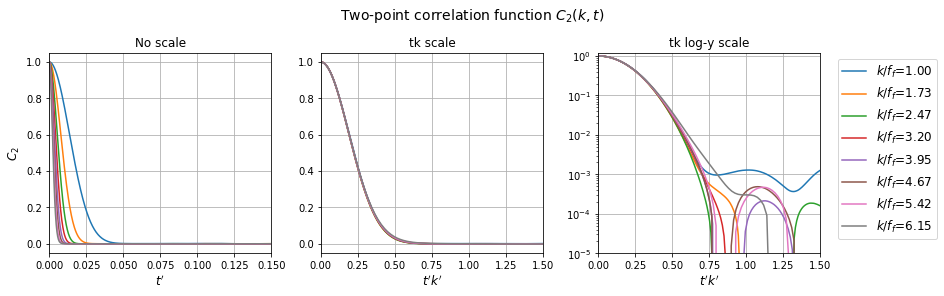

In [24]:
fig, (norm_scale, tk_scale, log_scale) = plt.subplots(nrows=1, ncols=3,figsize=(13,4), constrained_layout=True)
for ik in indices_of_k_to_plot :
    norm_scale.plot(t_corr/t0, correlation[:,ik]*normalization[ik])
    tk_scale.plot(t_corr/t0*(k[ik]/kL), correlation[:,ik]*normalization[ik])
    #tk23_scale.plot(t_corr/t0*(k[ik]/kL)**(2.0/3.0), correlation[:,ik]*normalization[ik])
    log_scale.semilogy(t_corr/t0*(k[ik]/kL), correlation[:,ik]*normalization[ik], label=r'$k/f_f$=%2.2f' % (k[ik]/k[ikf]))
norm_scale.set(title='No scale', ylabel=r'$C_2$', xlabel=r'$t^\prime$', xlim=[0,0.15]); norm_scale.grid()
tk_scale.set(title='tk scale', xlabel=r'$t^\prime k^\prime$', xlim=[0,1.5]); tk_scale.grid()
#tk23_scale.set(title=r'$tk^{2/3}$ scale', xlabel=r'$t^\prime {k^\prime}^{2/3}$', xlim=[0,1.0]); tk23_scale.grid()
log_scale.set(title='tk log-y scale', xlabel=r'$t^\prime k^\prime$', ylim=[10e-6, 1.2], xlim=[0,1.5]); log_scale.grid()
lgd = log_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.suptitle(r'Two-point correlation function $C_2(k,t)$', size=14) 
plt.show()

# pp = PdfPages('Images/transfer_decomp/2p_corr.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

# Plot T(k,t) correlation functions

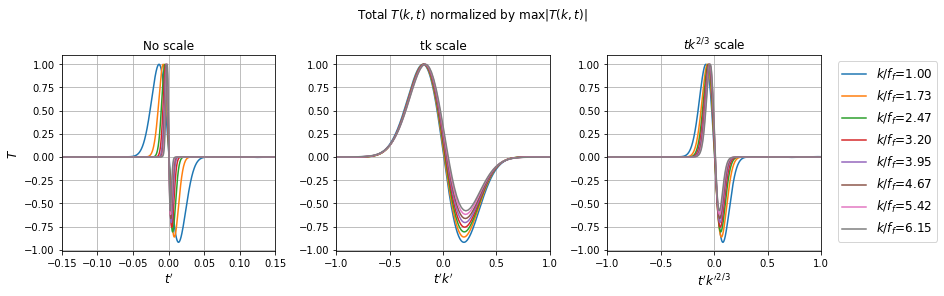

In [25]:
transf_norm = np.ones_like(t)    # no normalization
#transf_norm = 1.0/total_t[t_length//2,:]
#transf_norm = 1.0/correlation[0,:]
#transf_norm = 1.0/dissipation_spec
transf_norm = 1.0/np.amax(np.abs(total_t), axis=0)

fig, (norm_scale, tk_scale, tk23_scale) = plt.subplots(nrows=1, ncols=3,figsize=(13,4), constrained_layout=True)
for ik in indices_of_k_to_plot[::] :
    norm_scale.plot(t/t0, total_t[:,ik]*transf_norm[ik])
    tk_scale.plot(t/t0*(k[ik]/kL), total_t[:,ik]*transf_norm[ik])
    tk23_scale.plot(t/t0*(k[ik]/kL)**(2.0/3.0), total_t[:,ik]*transf_norm[ik], label=r'$k/f_f$=%2.2f' % (k[ik]/k[ikf]))
norm_scale.set(title='No scale', ylabel=r'$T$', xlabel=r'$t^\prime$', xlim=[-0.15, 0.15]); norm_scale.grid()
tk_scale.set(title='tk scale', xlabel=r'$t^\prime k^\prime$', xlim=[-1.0, 1.0], yscale='linear'); tk_scale.grid()
tk23_scale.set(title=r'$tk^{2/3}$ scale', xlabel=r'$t^\prime {k^\prime}^{2/3}$', xlim=[-1.0, 1.0]); tk23_scale.grid()
lgd = tk23_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sup = fig.suptitle(r'Total $T(k,t)$ normalized by max$|T(k,t)|$') 
#plt.show()

# pp = PdfPages('Images/transfer_decomp/t_total.pdf')
# pp.savefig(bbox_extra_artists=(lgd,sup, ), bbox_inches='tight')
# pp.close()

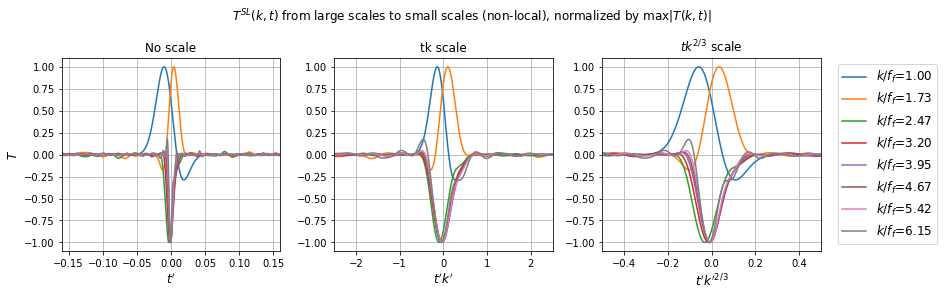

In [26]:
transf_norm = np.ones_like(t)    # no normalization
#transf_norm = 1.0/t_sl[t_length//2,:]
#transf_norm = 1.0/correlation[0,:]
#transf_norm = 1.0/dissipation_spec
transf_norm = 1.0/np.amax(np.abs(t_sl), axis=0)
skip_n = 0
fig, (norm_scale, tk_scale, tk23_scale) = plt.subplots(nrows=1, ncols=3,figsize=(13,4), constrained_layout=True)
for ax in [norm_scale, tk_scale, tk23_scale] : 
    ax.grid()
    ax.set_prop_cycle(default_cycler[skip_n::])
for ik in indices_of_k_to_plot[skip_n::] :
    label=r'$k/f_f$=%2.2f' % (k[ik]/k[ikf])
    norm_scale.plot(t/t0, t_sl[:,ik]*transf_norm[ik])
    tk_scale.plot(t/t0*(k[ik]/kL), t_sl[:,ik]*transf_norm[ik])
    tk23_scale.plot(t/t0*(k[ik]/kL)**(2/3), t_sl[:,ik]*transf_norm[ik],label=label)
norm_scale.set(title='No scale', ylabel=r'$T$', xlabel=r'$t^\prime$', xlim=[-0.16, 0.16]); 
tk_scale.set(title='tk scale', xlabel=r'$t^\prime k^\prime$', xlim=[-2.5, 2.5]); 
tk23_scale.set(title=r'$tk^{2/3}$ scale', xlabel=r'$t^\prime {k^\prime}^{2/3}$', xlim=[-0.5, 0.5]); 
lgd = tk23_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#fig.tight_layout()
sup = fig.suptitle(r'$T^{SL}(k,t)$ from large scales to small scales (non-local), normalized by max$|T(k,t)|$') 

# pp = PdfPages('Images/transfer_decomp/t_sl.pdf')
# pp.savefig(bbox_extra_artists=(lgd,sup, ), bbox_inches='tight')
# pp.close()

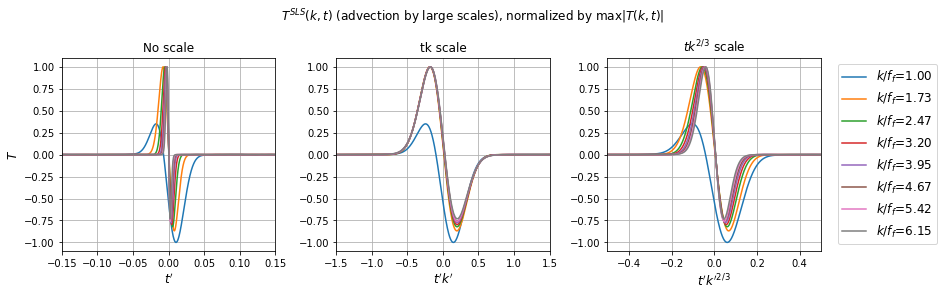

In [27]:
transf_norm = np.ones_like(t)    # no normalization
#transf_norm = 1.0/t_sls[t_length//2,:]  # normalize by T at t=0
#transf_norm = 1.0/correlation[0,:]      # normalize by C_2(k, t=0)
#transf_norm = 1.0/dissipation_spec      # normilize by dissipation spectrum
transf_norm = 1.0/np.amax(np.abs(t_sls), axis=0)
skip_n = 0
fig, (norm_scale, tk_scale, tk23_scale) = plt.subplots(nrows=1, ncols=3,figsize=(13,4), constrained_layout=True)
for ax in [norm_scale, tk_scale, tk23_scale] : 
    ax.grid()
    ax.set_prop_cycle(default_cycler[skip_n::])
for ik in indices_of_k_to_plot[skip_n::] :
    norm_scale.plot(t/t0, t_sls[:,ik]*transf_norm[ik])
    tk_scale.plot(t/t0*(k[ik]/kL), t_sls[:,ik]*transf_norm[ik])
    tk23_scale.plot(t/t0*(k[ik]/kL)**(2.0/3.0), t_sls[:,ik]*transf_norm[ik], label=r'$k/f_f$=%2.2f' % (k[ik]/k[ikf]))
norm_scale.set(title='No scale', ylabel=r'$T$', xlabel=r'$t^\prime$', xlim=[-0.15, 0.15]); 
tk_scale.set(title='tk scale', xlabel=r'$t^\prime k^\prime$', xlim=[-1.5, 1.5], yscale='linear'); 
tk23_scale.set(title=r'$tk^{2/3}$ scale', xlabel=r'$t^\prime {k^\prime}^{2/3}$', xlim=[-0.5, 0.5]);
lgd = tk23_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#fig.tight_layout()ls
sup = fig.suptitle(r'$T^{SLS}(k,t)$ (advection by large scales), normalized by max$|T(k,t)|$') 
#plt.show()
# pp = PdfPages('Images/transfer_decomp/t_sls.pdf')
# pp.savefig(bbox_extra_artists=(lgd,sup, ), bbox_inches='tight')
# pp.close()

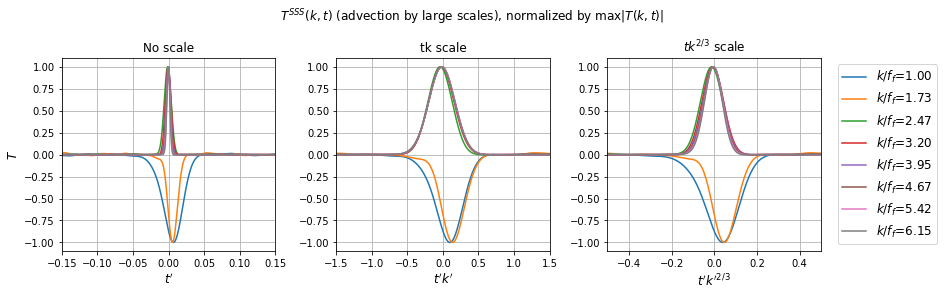

In [28]:
transf_norm = np.ones_like(t)    # no normalization
transf_norm = 1.0/np.amax(np.abs(t_sss), axis=0)

skip_n = 0
fig, (norm_scale, tk_scale, tk23_scale) = plt.subplots(nrows=1, ncols=3,figsize=(13,4), constrained_layout=True)
for ax in [norm_scale, tk_scale, tk23_scale] : 
    ax.grid()
    ax.set_prop_cycle(default_cycler[skip_n::])
for ik in indices_of_k_to_plot[skip_n::] :
    norm_scale.plot(t/t0, (t_sss[:,ik])*transf_norm[ik])
    tk_scale.plot(t/t0*(k[ik]/kL), (t_sss[:,ik])*transf_norm[ik])
    tk23_scale.plot(t/t0*(k[ik]/kL)**(2.0/3.0), (t_sss[:,ik])*transf_norm[ik], label=r'$k/f_f$=%2.2f' % (k[ik]/k[ikf]))
norm_scale.set(title='No scale', ylabel=r'$T$', xlabel=r'$t^\prime$', xlim=[-0.15, 0.15]); 
tk_scale.set(title='tk scale', xlabel=r'$t^\prime k^\prime$', xlim=[-1.5, 1.5], yscale='linear'); 
tk23_scale.set(title=r'$tk^{2/3}$ scale', xlabel=r'$t^\prime {k^\prime}^{2/3}$', xlim=[-0.5, 0.5]); 
lgd = tk23_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#fig.tight_layout()ls
sup = fig.suptitle(r'$T^{SSS}(k,t)$ (advection by large scales), normalized by max$|T(k,t)|$') 
#plt.show()
# pp = PdfPages('Images/transfer_decomp/t_sss.pdf')
# pp.savefig(bbox_extra_artists=(lgd,sup, ), bbox_inches='tight')
# pp.close()

# Contribution of different T at a fixed k

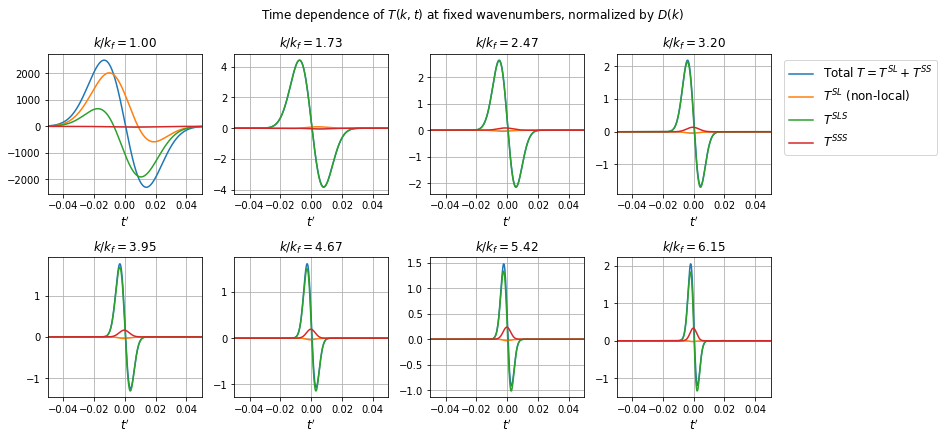

In [29]:
fig, axs = plt.subplots(nrows=nb_of_curves//4, ncols=4, constrained_layout=True,figsize=(13,6))

for i in list(range(nb_of_curves)) :
    #transf_norm = np.ones_like(t)   
    transf_norm = 1.0/dissipation_spec[ik]
    ik = indices_of_k_to_plot[i]
    ax = axs.flat[i]
    ax.plot(t/t0, total_t[:,ik]*transf_norm, '-', label=r'Total $T = T^{SL} + T^{SS}$')
    ax.plot(t/t0, t_sl[:,ik]*transf_norm, '-', label=r'$T^{SL}$ (non-local)')
    ax.plot(t/t0, t_sls[:,ik]*transf_norm, '-', label=r'$T^{SLS}$')
    ax.plot(t/t0, t_sss[:,ik]*transf_norm, '-', label=r'$T^{SSS}$')
    ax.set(xlabel=r'$t^\prime$', title=r'$k/k_{f}=$%2.2f' % (k[ik]/k[ikf]), xlim=[-0.05, 0.05]); ax.grid()
    #ax.set(yscale='log')
    if (i == 3) :
        lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.suptitle(r'Time dependence of $T(k,t)$ at fixed wavenumbers, normalized by $D(k)$')
plt.show()
# pp = PdfPages('Images/transfer_decomp/t_contributions.pdf')
# pp.savefig(bbox_extra_artists=(lgd,sup, ), bbox_inches='tight')
# pp.close()

# Max, min, zero

In [30]:
def find_zero_x(vector_x, vector_y):   
    try :
        zero_index = np.flatnonzero(vector_y <= 0.0)[0] 
        zero_x = vector_x[zero_index]
    except : 
        zero_x = np.nan
    return zero_x

In [31]:
# zero_times_total_t = np.ndarray(shape=(wavenumbers_length), dtype=float)

# tk1 =-0.1
# tk2 = 1.0
# for ik in list(range(4,wavenumbers_length)) :
#     a = np.searchsorted(t/t0*k[ik]/kL, tk1)
#     b = np.searchsorted(t/t0*k[ik]/kL, tk2)
#     zero_times_total_t[ik] = find_zero_x(t[a:b], total_t[a:b,ik])

# fig, (ax_zero_time) = plt.subplots(tight_layout=True)
# ax_zero_time.plot(k, zero_times_total_t, '.-', label='T total')

# ax_zero_time.set(title='Time of zero T')
# #ax_zero_time.set(xlim=[4,63],ylim=[-0.15,0.15])
# ax_zero_time.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.show()

In [32]:
def find_min_max(x_vector, y_vector) :
    index_min = np.argmin(y_vector)
    index_max = np.argmax(y_vector)
    index_max_abs = np.argmax(np.abs(y_vector))
    return [x_vector[index_min], y_vector[index_min], x_vector[index_max], y_vector[index_max], y_vector[index_max_abs]]

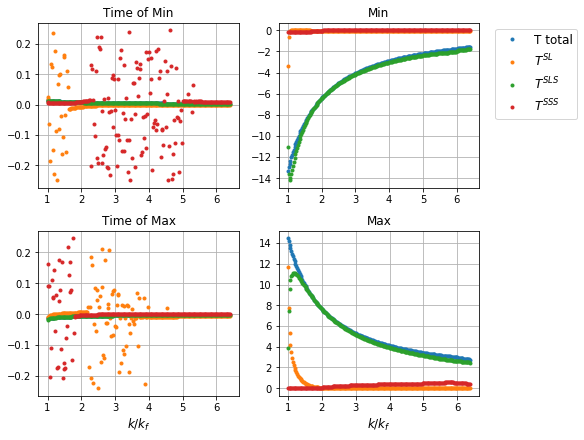

In [33]:
total_t_prop = {'legend': 'T total'}; t_sss_prop={'legend': r'$T^{SSS}$'}; t_sls_prop={'legend': r'$T^{SLS}$'}; t_sl_prop={'legend': r'$T^{SL}$'}
for dictionary in [total_t_prop, t_sss_prop, t_sls_prop, t_sl_prop] : 
    dictionary.update({'min': np.ndarray(shape=(wavenumbers_length), dtype=float), 'max': np.ndarray(shape=(wavenumbers_length), dtype=float), 't_min': np.ndarray(shape=(wavenumbers_length), dtype=float), 't_max' : np.ndarray(shape=(wavenumbers_length), dtype=float), 'max_abs' : np.ndarray(shape=(wavenumbers_length), dtype=float)})

for ik in list(range(wavenumbers_length)) :
    [total_t_prop['t_min'][ik], total_t_prop['min'][ik], total_t_prop['t_max'][ik], total_t_prop['max'][ik], total_t_prop['max_abs'][ik]] = find_min_max(t, total_t[:,ik])
    [t_sl_prop['t_min'][ik], t_sl_prop['min'][ik], t_sl_prop['t_max'][ik], t_sl_prop['max'][ik], t_sl_prop['max_abs'][ik]] = find_min_max(t, t_sl[:,ik])
    [t_sls_prop['t_min'][ik], t_sls_prop['min'][ik], t_sls_prop['t_max'][ik], t_sls_prop['max'][ik], t_sls_prop['max_abs'][ik]] = find_min_max(t, t_sls[:,ik])
    [t_sss_prop['t_min'][ik], t_sss_prop['min'][ik], t_sss_prop['t_max'][ik], t_sss_prop['max'][ik], t_sss_prop['max_abs'][ik]] = find_min_max(t, t_sss[:,ik])

fig, ((ax_time_min, ax_min), (ax_time_max, ax_max)) = plt.subplots(nrows=2, ncols=2,figsize=(8,6), constrained_layout=True)    
x = k[ikf::]/k[ikf]
for dictionary in [total_t_prop, t_sl_prop, t_sls_prop, t_sss_prop] : 
    ax_time_min.plot(x, dictionary['t_min'][ikf::]/t0, '.')
    ax_min.plot(x, dictionary['min'][ikf::]/dissipation_spec[ikf::], '.', label=dictionary['legend'])
    ax_time_max.plot(x, dictionary['t_max'][ikf::]/t0, '.')
    ax_max.plot(x[:-1], dictionary['max'][ikf:-1:]/dissipation_spec[ikf:-1:], '.')

ax_time_min.set(title='Time of Min'); ax_min.set(title='Min'); ax_time_max.set(title='Time of Max', xlabel=r'$k/k_f$'); ax_max.set(title='Max', xlabel=r'$k/k_f$')
ax_time_min.grid(); ax_min.grid(); ax_time_max.grid(); ax_max.grid()
lgd = ax_min.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.show()
# pp = PdfPages('Images/transfer_decomp/min_max.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

# Correlation fit

In [34]:
# Define the functions to fit

def linear_mult_gaussian(x, a, b, c):   
    return c*(1-b*x) * np.exp(-a * x**2) 
nb_of_params = 3

def simple_gaussian(x, a, c):   
    return c*np.exp(-a * (x)**2.0) 
nb_of_params_corr = 2

In [35]:
def try_to_fit(curve_function, xdata, ydata) :
    number_of_params_of_optimization = len(signature(curve_function).parameters)-1
    coefficients = np.ndarray(shape=(number_of_params_of_optimization), dtype=float) 
    covariance_matrix = np.ndarray(shape=(number_of_params_of_optimization, number_of_params_of_optimization), dtype=float) 
    try :
        coefficients, covariance_matrix = curve_fit(curve_function, xdata, ydata)
    except :
        #print('[DEBUG] Failed optimization for ik = ', ik)
        coefficients.fill(np.nan); covariance_matrix.fill(np.nan)
    return coefficients

In [36]:
# allocate array to store the coefficents of fitting
for dictionary in [total_t_prop, t_sss_prop, t_sls_prop, t_sl_prop] : 
    dictionary.update({'optim_coef' : np.ndarray(shape=(wavenumbers_length, 3), dtype=float)})

corr_prop={'legend' : r'$C_2$'}
corr_prop.update({'optim_coef' : np.ndarray(shape=(wavenumbers_length, 2), dtype=float)})

In [37]:
tk1_fit = -1.0
tk2_fit = 1.0

for ik in range(wavenumbers_length) :
    # fit the 2-point correlation function :
    a = np.searchsorted(t_corr/t0*k[ik]/kL, 0.0)
    b = np.searchsorted(t_corr/t0*k[ik]/kL, tk2_fit)
    corr_prop['optim_coef'][ik, :] = try_to_fit(simple_gaussian, t_corr[a:b]/t0, correlation[a:b, ik]*normalization[ik])

    # fit the energy transfer functions : 
    a = np.searchsorted(t/t0*k[ik]/kL, tk1_fit)
    b = np.searchsorted(t/t0*k[ik]/kL, tk2_fit)
    time_vector = t[a:b]/t0   # t' variable
    normalization_coef = 1.0 / dissipation_spec[ik]
    #normalization_coef = 1.0 / kinetic_energy[ik]
    total_t_prop['optim_coef'][ik, :] = try_to_fit(linear_mult_gaussian, time_vector, total_t[a:b, ik]*normalization_coef)
    t_sss_prop['optim_coef'][ik, :] = try_to_fit(linear_mult_gaussian, time_vector, t_sss[a:b, ik]*normalization_coef)
    t_sls_prop['optim_coef'][ik, :] = try_to_fit(linear_mult_gaussian, time_vector, t_sls[a:b, ik]*normalization_coef)
    t_sl_prop['optim_coef'][ik, :] = try_to_fit(linear_mult_gaussian, time_vector, t_sl[a:b, ik]*normalization_coef)

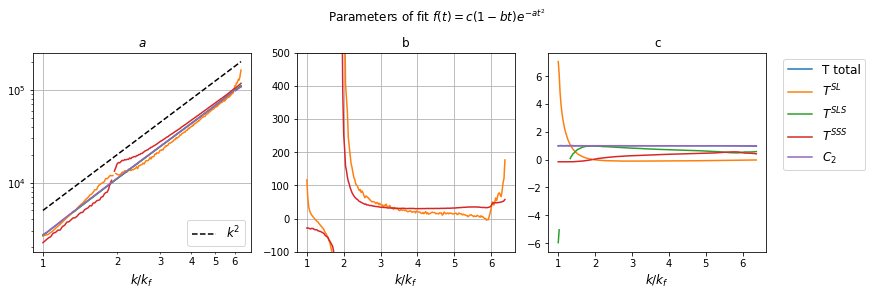

In [38]:
# plot fitting coeffiecients
import matplotlib.ticker 

ik1 = ikf; ik2 = wavenumbers_length-1
x = k[ik1:ik2]/k[ikf]
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(12,4), constrained_layout=True)

#for dictionary in [total_t_prop, t_sss_prop, t_sls_prop, t_sl_prop] : 
for dictionary in [total_t_prop, t_sl_prop, t_sls_prop, t_sss_prop] : 
    ax_a.plot(x, dictionary['optim_coef'][ik1:ik2,0])
    ax_b.plot(x, dictionary['optim_coef'][ik1:ik2,1])
    ax_c.plot(x, dictionary['optim_coef'][ik1:ik2,2], label=dictionary['legend'])

ax_a.plot(x, corr_prop['optim_coef'][ik1:ik2,0])
ax_c.plot(x, corr_prop['optim_coef'][ik1:ik2,1], label=corr_prop['legend'])

ax_a.plot(x, 50e2*x**2.0, '--', color='black', label=r'$k^2$')
ax_a.legend(loc='lower right')

ax_a.set(title=r'$a$', xlabel=r'$k/k_f$', xscale='log', yscale='log'); ax_a.grid(); 
ax_b.set(title='b', xlabel=r'$k/k_f$', xscale='linear', ylim=[-100, 500]); ax_b.grid()
ax_c.set(xscale='linear', yscale='linear', title='c', xlabel=r'$k/k_f$');# ax_c.grid(): ax_c.set(ylim=[-0.3, 2])
#ax_c.axhspan(ax_c.get_ylim()[0], 0, facecolor='red', alpha=0.15)
ax_a.xaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%d'))
ax_a.xaxis.set_minor_formatter(matplotlib.ticker.FormatStrFormatter('%d'))

lgd = ax_c.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
sup = fig.suptitle(r'Parameters of fit $f(t) = c (1-b t) e^{-a t^2} $')

#plt.show()
# pp = PdfPages('Images/transfer_decomp/fit.pdf')
# pp.savefig(bbox_extra_artists=(lgd,sup,), bbox_inches='tight')
# pp.close()

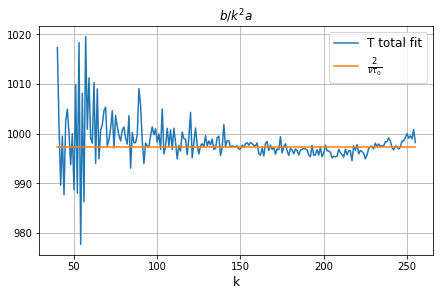

In [39]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(k[ik1:ik2], total_t_prop['optim_coef'][ik1:ik2, 1]/(total_t_prop['optim_coef'][ik1:ik2, 0]/(k[ik1:ik2])**2.0), label='T total fit')
#ax.plot(k[ik1:ik2], optim_coef2[ik1:ik2, 1]/(optim_coef2[ik1:ik2, 0]/(k[ik1:ik2])**2.0), label='Filtered')
ax.plot(k[ik1:ik2], np.ones_like(k[ik1:ik2])*2.0/nu/t0, label=r'$\frac{2}{\nu \tau_0}$')
ax.legend()
ax.set(xlabel='k', title=r'$b/k^2 a$'); ax.grid()
plt.show()

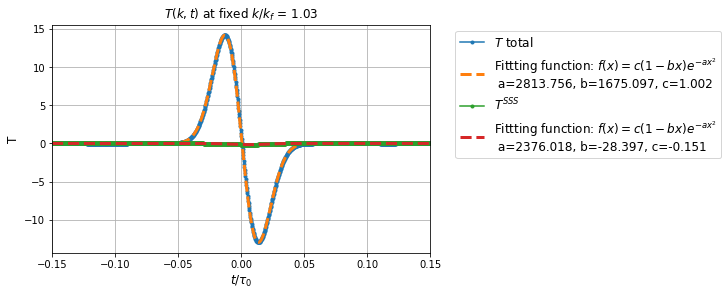

In [40]:
fig, (ax) = plt.subplots(figsize=(10,4), constrained_layout=True)
x = t/t0
ik = 40

ax.plot(x, total_t[:,ik] / dissipation_spec[ik], '.-', label=r'$T$ total')
ax.plot(x, linear_mult_gaussian(x, *total_t_prop['optim_coef'][ik,:]), '--', linewidth=3, label=r'Fittting function: $f(x) = c(1-bx) e^{-a x^2}$' + "\n" + ' a=%5.3f, b=%5.3f, c=%5.3f' % tuple(total_t_prop['optim_coef'][ik,:]))

ax.plot(x, t_sss[:,ik] / dissipation_spec[ik], '.-', label=r'$T^{SSS}$')
ax.plot(x, linear_mult_gaussian(x, *t_sss_prop['optim_coef'][ik,:]), '--', linewidth=3, label=r'Fittting function: $f(x) = c(1-bx) e^{-a x^2}$' + "\n" + ' a=%5.3f, b=%5.3f, c=%5.3f' % tuple(t_sss_prop['optim_coef'][ik,:]))

ax.set(yscale="linear", ylabel='T', xlabel=r'$t/\tau_0$', title=r'$T(k,t)$ at fixed $k/k_f$ = %2.2f' % (k[ik]/k[ikf])); ax.grid()
#ax.set(ylim=(10e-2,10))
ax.set(xlim=(-0.15,0.15))
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

#plt.show()
# pp = PdfPages('Images/transfer_decomp/fit_compare.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()

# Integral decorrelation time scales

In [41]:
for dictionary in [total_t_prop, t_sss_prop, t_sls_prop, t_sl_prop, corr_prop] : 
    dictionary.update({'integral_decorrelation_time' : np.ndarray(shape=(wavenumbers_length), dtype=float)})

In [42]:
for ik in list(range(wavenumbers_length)) : 
    corr_prop['integral_decorrelation_time'][ik] = np.trapz(correlation[:,ik]*normalization[ik], x=t_corr)
    #total_t_prop['integral_decorrelation_time'][ik] = np.trapz(total_t[:,ik]/total_t_prop['max_abs'][ik], x=t)
    total_t_prop['integral_decorrelation_time'][ik] = 1.0/total_t_prop['optim_coef'][ik,1]
    t_sss_prop['integral_decorrelation_time'][ik] = np.trapz(t_sss[:,ik]/t_sss_prop['max_abs'][ik], x=t)
    #t_sls_prop['integral_decorrelation_time'][ik] = np.trapz(t_sls[:,ik]/t_sls_prop['max_abs'][ik], x=t)
    t_sls_prop['integral_decorrelation_time'][ik] = 1.0/t_sls_prop['optim_coef'][ik,1]
    t_sl_prop['integral_decorrelation_time'][ik] = np.trapz(t_sl[:,ik]/t_sl_prop['max_abs'][ik], x=t)
#    corr_prop['integral_decorrelation_time'][ik] = np.trapz(correlation[:,ik]*t_corr, x=t_corr)/np.trapz(correlation[:,ik], x=t_corr)
#     total_t_prop['integral_decorrelation_time'][ik] = np.abs(np.trapz(total_t[:,ik]*t, x=t)/np.trapz(total_t[:,ik], x=t))
#     t_sss_prop['integral_decorrelation_time'][ik] = np.abs(np.trapz(t_sss[:,ik]*t, x=t)/np.trapz(t_sss[:,ik], x=t))
#     t_sls_prop['integral_decorrelation_time'][ik] = np.abs(np.trapz(t_sls[:,ik]*t, x=t)/np.trapz(t_sls[:,ik], x=t))
#     t_sl_prop['integral_decorrelation_time'][ik] = np.abs(np.trapz(t_sl[:,ik]*t, x=t)/np.trapz(t_sl[:,ik], x=t))

In [43]:
# fig, ax = plt.subplots(constrained_layout=True)
# x = k[ik2f::]
# ax.plot(x, t_sls_prop['integral_decorrelation_time'][ik2f::])
# ax.set(xscale='log', yscale='log')
# plt.show()

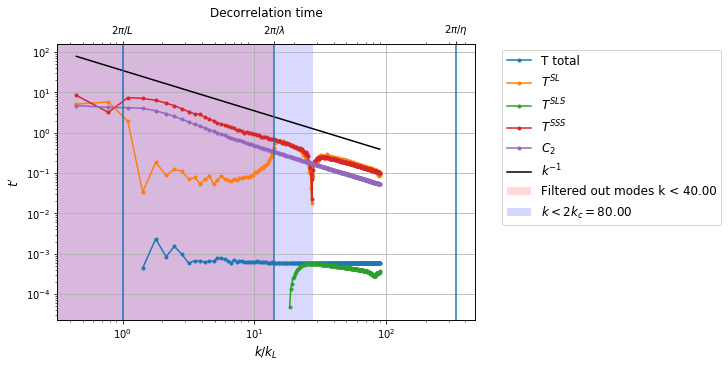

In [44]:
fig, (ax) = plt.subplots(figsize=(10,5), constrained_layout=True)

for dictionary in [total_t_prop, t_sl_prop, t_sls_prop, t_sss_prop, corr_prop] : 
#for dictionary in [corr_prop] : 
    ax.plot(k/kL, dictionary['integral_decorrelation_time'], '.-', label=dictionary['legend'])

ax.plot(k/kL, 10e1*(k)**(-1), '-', label=r'$k^{-1}$', color='black')
#ax.plot(k/kL, 15e3*(k)**(-0.5), '-', label=r'$k^{-2}$', color='blue')

ax.set(xscale='log', yscale='log', xlabel=r'$k/k_L$', ylabel=r'$t^{\prime}$', title=r'Decorrelation time')

for line in vertical_lines : ax.axvline(x=line)
ax.axvspan(0, cut_off_k/kL, facecolor='red', alpha=0.15, label='Filtered out modes k < %2.2f' % (cut_off_k))
ax.axvspan(0, 2*cut_off_k/kL, facecolor='blue', alpha=0.15, label=r'$k < 2k_c = $%2.2f' % (2*cut_off_k))

vertical_lines=wn_scales/kL
ax2 = ax.twiny()
ax2.set(xscale='log', yscale='log', xlim = ax.get_xlim())
ax2.set_xticks(vertical_lines); ax2.set_xticklabels([r'$2\pi/L$', r'$2\pi/\lambda$', r'$2\pi/\eta$'])

ax.grid()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.show()
# pp = PdfPages('Images/transfer_decomp/decorr_time.pdf')
# pp.savefig(bbox_extra_artists=(lgd,), bbox_inches='tight')
# pp.close()